
Rastrigin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util = 'ERM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3


In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
            
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]
    
    def ERM(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
    
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_exact = BOLD + OKGREEN + min_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc_exact, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

n_start = n_start_AcqFunc

class dGPGO(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B'):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_approx = BOLD + OKGREEN + min_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc, min_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_19 = 19


***Explanation:*** Why does optimising negative EI with exact (negative) EI gradients, outperform approximate (negative) EI gradients for (negative) EI optimisation?


1. Considering the best (**x**, *y*) point sampled by the exact (negative) EI gradients' model



In [12]:
### ESTIMATED STP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.73630094 -5.12      ]	 62.216935372653	 25.867003842388073	 -20.076729605686424	 -20.076752102244
2  	 [ 1.58859015 -1.47089093]	 43.010759282267614	 25.867003842388073	 -22.65996690076708	 -22.660621681453506


In [13]:
### EXACT STP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82677578 -3.73089453]	 53.77585428936947	 25.867003842388073	 -20.076729605686424	 -20.076752102244
2	 [-0.58954654  0.0049192 ]	 18.81087714764606	 18.81087714764606	 -21.698599278068155	 -21.70141253540014


In [14]:
approx_19.start_points_arr


array([[ 1.56343684,  2.15790258],
       [-1.01429932,  4.21710172],
       [-4.56788076, -0.04910937],
       [-2.56370032, -1.55165838],
       [ 2.4666744 , -1.42175224],
       [ 1.33879911,  4.85612391],
       [-0.79699497, -4.47211775],
       [-4.31526895, -3.01192987],
       [-2.17578049, -1.2137512 ],
       [ 3.43231841, -4.27954414],
       [ 3.28534909,  3.2425705 ],
       [-1.70910004,  1.79846925],
       [ 4.9503824 ,  4.70220083],
       [ 1.74022559,  4.02392727],
       [-1.56100886,  1.34825517],
       [-3.18982968, -1.55356609],
       [ 4.96411722,  2.57670389],
       [ 3.41053484, -3.66560704],
       [-4.96661302,  3.65849059],
       [ 2.17032133,  3.65097151]])

In [15]:
exact_19.start_points_arr


array([[ 1.56343684,  2.15790258],
       [-1.01429932,  4.21710172],
       [-4.56788076, -0.04910937],
       [-2.56370032, -1.55165838],
       [ 2.4666744 , -1.42175224],
       [ 1.33879911,  4.85612391],
       [-0.79699497, -4.47211775],
       [-4.31526895, -3.01192987],
       [-2.17578049, -1.2137512 ],
       [ 3.43231841, -4.27954414],
       [ 3.28534909,  3.2425705 ],
       [-1.70910004,  1.79846925],
       [ 4.9503824 ,  4.70220083],
       [ 1.74022559,  4.02392727],
       [-1.56100886,  1.34825517],
       [-3.18982968, -1.55356609],
       [ 4.96411722,  2.57670389],
       [ 3.41053484, -3.66560704],
       [-4.96661302,  3.65849059],
       [ 2.17032133,  3.65097151]])

In [16]:
np.sum((exact_19.start_points_arr - approx_19.start_points_arr)**2)


0.0

In [17]:
np.round(approx_19.f_best, 5), np.argmin(approx_19.f_best)


(array([-22.66062, -22.64424, -22.64382, -22.65702, -22.66062, -22.64424,
        -22.64872, -22.64382, -22.65702, -22.65702, -22.64872, -22.65702,
        -22.64872, -22.64424, -22.65702, -22.64382, -22.64872, -22.66062,
        -22.34471, -22.64872]), 0)

In [18]:
min(approx_19.f_best), np.round(max(approx_19.f_best), 4)


(-22.660621681453506, -22.3447)

In [19]:
approx_19.x_best[np.argmin(approx_19.f_best)], approx_19.best


(array([ 1.58859015, -1.47089093]), array([ 1.58859015, -1.47089093]))

In [20]:
np.round(exact_19.f_best, 5), np.argmin(exact_19.f_best)


(array([-21.6986 , -21.60177, -21.68552, -21.69778, -21.64124, -21.69042,
        -21.68103, -21.52752, -21.6981 , -21.65382, -21.69042, -21.51736,
        -21.69042, -21.69042, -21.58577, -21.68929, -21.69042, -21.65382,
        -21.68595, -21.69042]), 0)

In [21]:
min(exact_19.f_best), np.round(max(exact_19.f_best), 4)


(-21.698599278068155, -21.5174)

In [22]:
exact_19.x_best[np.argmin(exact_19.f_best)], exact_19.best


(array([-0.58954654,  0.0049192 ]), array([-0.58954654,  0.0049192 ]))

In [23]:
np.sum((exact_19.f_best - approx_19.f_best)**2)


19.296318200365516

In [24]:
exact_19.x_best


array([[-5.89546540e-01,  4.91919935e-03],
       [-1.01429932e+00,  4.21710172e+00],
       [-5.12000000e+00, -9.78993144e-01],
       [-8.34899404e-01,  1.77142539e-01],
       [ 2.36759787e+00, -1.52082877e+00],
       [ 5.12000000e+00,  5.12000000e+00],
       [ 1.66432361e+00, -2.01079918e+00],
       [-5.12000000e+00, -5.12000000e+00],
       [-8.49788665e-01,  1.12240634e-01],
       [ 1.55383624e+00, -5.12000000e+00],
       [ 5.12000000e+00,  5.12000000e+00],
       [-1.09833154e+00,  2.40923774e+00],
       [ 5.12000000e+00,  5.12000000e+00],
       [ 5.12000000e+00,  5.12000000e+00],
       [-1.12456258e+00,  1.78470145e+00],
       [-1.18326467e+00,  4.52998920e-01],
       [ 5.12000000e+00,  5.12000000e+00],
       [ 1.55349742e+00, -5.12000000e+00],
       [-1.28709552e+00,  5.12000000e+00],
       [ 5.12000000e+00,  5.12000000e+00]])

In [25]:
np.sum((exact_19.x_best - exact_19.start_points_arr)**2)


123.25166728752001

In [26]:
approx_19.x_best


array([[ 1.58859015, -1.47089093],
       [-1.28691307,  5.12      ],
       [-5.12      , -0.97846585],
       [-0.54172274, -0.08328283],
       [ 1.58873531, -1.47112816],
       [-1.28693572,  5.12      ],
       [ 5.12      ,  5.12      ],
       [-5.12      , -0.97851006],
       [-0.53836552, -0.08527134],
       [-0.53873887, -0.08502221],
       [ 5.12      ,  5.12      ],
       [-0.53907867, -0.08482102],
       [ 5.12      ,  5.12      ],
       [-1.28693766,  5.12      ],
       [-0.53855005, -0.08514566],
       [-5.12      , -0.97849811],
       [ 5.12      ,  5.12      ],
       [ 1.58771404, -1.47045932],
       [-5.12      ,  5.12      ],
       [ 5.12      ,  5.12      ]])

In [27]:
np.sum((approx_19.x_best - approx_19.start_points_arr)**2)


255.51189946968407

In [28]:
np.sum((exact_19.x_best - approx_19.x_best)**2)


256.4115631540155

In [29]:
a = approx_19.best[0]
b = approx_19.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


43.010759282267614

In [30]:
a = exact_19.best[0]
b = exact_19.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


18.81087714764606

In [31]:
xBest0 = 0.0898
xBest1 = -0.7126

xBest = [xBest0, xBest1]
xBest


[0.0898, -0.7126]

In [32]:
def check(x):
  a = x[:,0]
  b = x[:,1] 
  for i in range(0, len(a) - 1):
    res = (a - xBest0)**2 + (b - xBest1)**2 
    return np.sum(res)

check(approx_19.x_best), check(exact_19.x_best)


(559.5655436549754, 570.3255218831085)

In [33]:
np.std(approx_19.x_best), np.std(exact_19.x_best)


(3.361209376373263, 3.4555212174189873)

In [34]:
np.mean(approx_19.x_best), np.mean(exact_19.x_best)


(1.0409075431206227, 1.1191297002407283)

In [35]:
approx_19_20rms = pd.Series(np.round(approx_19.f_best, 2)).value_counts(sort=True)
approx_19_20rms_df = pd.DataFrame({'Frequency':approx_19_20rms.values,'STP ERM':approx_19_20rms.index})
approx_19_20rms_df


,Frequency,STP ERM
0,8,-22.66
1,6,-22.64
2,5,-22.65
3,1,-22.34


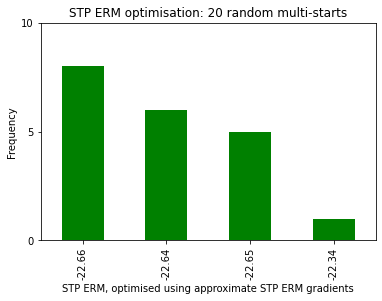

In [36]:
ax = approx_19_20rms.plot.bar(title="STP ERM optimisation: 20 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="green", yticks=[0,5,10])


In [37]:
exact_19_20rms = pd.Series(np.round(exact_19.f_best, 2)).value_counts(sort=True)
exact_19_20rms_df = pd.DataFrame({'Frequency':exact_19_20rms.values,'STP ERM':exact_19_20rms.index})
exact_19_20rms_df


,Frequency,STP ERM
0,9,-21.69
1,3,-21.70
2,2,-21.65
3,1,-21.60
4,1,-21.64
5,1,-21.68
6,1,-21.53
7,1,-21.52
8,1,-21.59


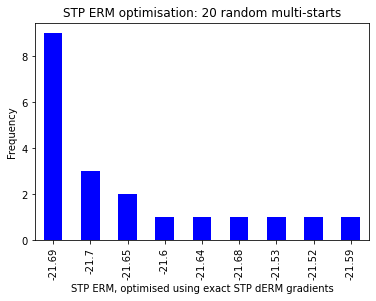

In [38]:
ax = exact_19_20rms.plot.bar(title="STP ERM optimisation: 20 random multi-starts", xlabel="STP ERM, optimised using exact STP dERM gradients", ylabel="Frequency", color="blue")


In [39]:
n_start = 50


In [40]:
### ESTIMATED STP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_19)
surrogate_approx_19_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19_50rms = GPGO_multi(surrogate_approx_19_50rms, Acquisition_grad(util), objfunc, param)
approx_19_50rms.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.73630094 -5.12      ]	 62.216935372653	 25.867003842388073	 -20.07675178290837	 -20.076752102244
2  	 [ 1.58848923 -1.4708275 ]	 43.01287505176613	 25.867003842388073	 -22.660604243421243	 -22.66062168148467


In [41]:
### EXACT STP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_19)
surrogate_exact_19_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19_50rms = dGPGO(surrogate_exact_19_50rms, Acquisition_grad(util), objfunc, param)
exact_19_50rms.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.21710172 -4.56788076]	 65.70127216515351	 25.867003842388073	 -20.07675178290837	 -20.076752102244
2	 [ 0.88162509 -0.88036673]	 6.887665470440714	 6.887665470440714	 -23.08247392998115	 -23.08289083799996


In [42]:
approx_19_50rms = pd.Series(np.round(approx_19_50rms.f_best, 2)).value_counts(sort=True)
approx_19_50rms_df = pd.DataFrame({'Frequency':approx_19_50rms.values,'STP ERM':approx_19_50rms.index})
approx_19_50rms_df


,Frequency,STP ERM
0,25,-22.66
1,13,-22.64
2,6,-22.65
3,3,-22.49
4,3,-22.54


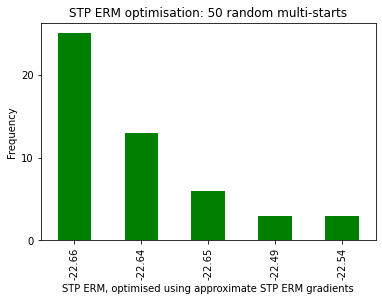

In [43]:
ax = approx_19_50rms.plot.bar(title="STP ERM optimisation: 50 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="green", yticks=[0,10,20])


In [44]:
exact_19_50rms = pd.Series(np.round(exact_19_50rms.f_best, 2)).value_counts(sort=True)
exact_19_50rms_df = pd.DataFrame({'Frequency':exact_19_50rms.values,'STP ERM':exact_19_50rms.index})
exact_19_50rms_df


,Frequency,STP ERM
0,16,-23.07
1,11,-23.08
2,3,-22.91
3,3,-22.89
4,3,-22.81
5,2,-23.00
6,1,-22.78
7,1,-22.82
8,1,-22.87
9,1,-22.95


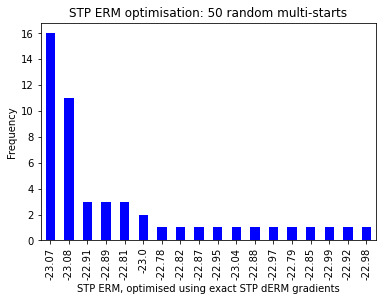

In [45]:
ax = exact_19_50rms.plot.bar(title="STP ERM optimisation: 50 random multi-starts", xlabel="STP ERM, optimised using exact STP dERM gradients", ylabel="Frequency", color="blue")


In [46]:
n_start = 100


In [47]:
### ESTIMATED STP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_19)
surrogate_approx_19_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19_100rms = GPGO_multi(surrogate_approx_19_100rms, Acquisition_grad(util), objfunc, param)
approx_19_100rms.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 -20.07675178290837	 -20.076752106543875
2  	 [ 1.77595324 -1.68632923]	 28.268935573954998	 25.867003842388073	 -22.15268137303795	 -22.15271976759985


In [48]:
### EXACT STP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_19)
surrogate_exact_19_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19_100rms = dGPGO(surrogate_exact_19_100rms, Acquisition_grad(util), objfunc, param)
exact_19_100rms.run(init_evals=n_init, max_iter=2)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.21710172 -4.56788076]	 65.70127216515351	 25.867003842388073	 -20.07675178290837	 -20.076752106543875
2	 [ 1.15665688 -1.04918173]	 7.3778828364040425	 7.3778828364040425	 -23.082885474157443	 -23.082890838004005


In [49]:
approx_19_100rms = pd.Series(np.round(approx_19_100rms.f_best, 2)).value_counts(sort=True)
approx_19_100rms_df = pd.DataFrame({'Frequency':approx_19_100rms.values,'STP ERM':approx_19_100rms.index})
approx_19_100rms_df


,Frequency,STP ERM
0,55,-22.15
1,37,-22.14
2,5,-21.98
3,2,-22.10
4,1,-22.03


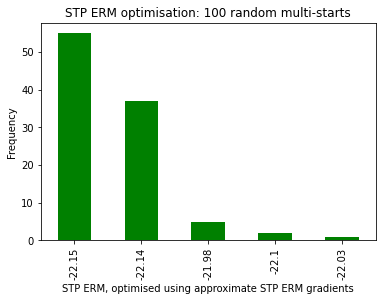

In [50]:
ax = approx_19_100rms.plot.bar(title="STP ERM optimisation: 100 random multi-starts", xlabel="STP ERM, optimised using approximate STP ERM gradients", ylabel="Frequency", color="green")


In [51]:
exact_19_100rms = pd.Series(np.round(exact_19_100rms.f_best, 2)).value_counts(sort=True)
exact_19_100rms_df = pd.DataFrame({'Frequency':exact_19_100rms.values,'STP ERM':exact_19_100rms.index})
exact_19_100rms_df


,Frequency,STP ERM
0,28,-23.07
1,21,-23.08
2,10,-22.91
3,7,-22.79
4,4,-23.02
5,3,-23.00
6,2,-23.04
7,2,-22.88
8,2,-22.92
9,2,-22.78


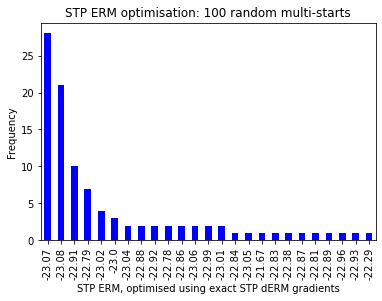

In [52]:
ax = exact_19_100rms.plot.bar(title="STP ERM optimisation: 100 random multi-starts", xlabel="STP ERM, optimised using exact STP dERM gradients", ylabel="Frequency", color="blue")


In [53]:
print(approx_19_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &  0 \\
\midrule
-22.66 &  8 \\
-22.64 &  6 \\
-22.65 &  5 \\
-22.34 &  1 \\
\bottomrule
\end{tabular}



In [54]:
print(exact_19_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &  0 \\
\midrule
-21.69 &  9 \\
-21.70 &  3 \\
-21.65 &  2 \\
-21.60 &  1 \\
-21.64 &  1 \\
-21.68 &  1 \\
-21.53 &  1 \\
-21.52 &  1 \\
-21.59 &  1 \\
\bottomrule
\end{tabular}



In [55]:
print(approx_19_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-22.66 &  25 \\
-22.64 &  13 \\
-22.65 &   6 \\
-22.49 &   3 \\
-22.54 &   3 \\
\bottomrule
\end{tabular}



In [56]:
print(exact_19_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-23.07 &  16 \\
-23.08 &  11 \\
-22.91 &   3 \\
-22.89 &   3 \\
-22.81 &   3 \\
-23.00 &   2 \\
-22.78 &   1 \\
-22.82 &   1 \\
-22.87 &   1 \\
-22.95 &   1 \\
-23.04 &   1 \\
-22.88 &   1 \\
-22.97 &   1 \\
-22.79 &   1 \\
-22.85 &   1 \\
-22.99 &   1 \\
-22.92 &   1 \\
-22.98 &   1 \\
\bottomrule
\end{tabular}



In [57]:
print(approx_19_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-22.15 &  55 \\
-22.14 &  37 \\
-21.98 &   5 \\
-22.10 &   2 \\
-22.03 &   1 \\
\bottomrule
\end{tabular}



In [58]:
print(exact_19_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-23.07 &  28 \\
-23.08 &  21 \\
-22.91 &  10 \\
-22.79 &   7 \\
-23.02 &   4 \\
-23.00 &   3 \\
-23.04 &   2 \\
-22.88 &   2 \\
-22.92 &   2 \\
-22.78 &   2 \\
-22.86 &   2 \\
-23.06 &   2 \\
-22.99 &   2 \\
-23.01 &   2 \\
-22.84 &   1 \\
-23.05 &   1 \\
-21.67 &   1 \\
-22.83 &   1 \\
-22.38 &   1 \\
-22.87 &   1 \\
-22.81 &   1 \\
-22.89 &   1 \\
-22.96 &   1 \\
-22.93 &   1 \\
-22.29 &   1 \\
\bottomrule
\end{tabular}

